<a href="https://colab.research.google.com/github/dojian/MLproject/blob/kristen/Chart_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.1/660.1 kB 10.7 MB/s eta 0:00:00


In [ ]:
# Import libraries

import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt, atan2, pi
from PIL import Image, ImageDraw
from ultralytics import YOLO
from sklearn.preprocessing import LabelBinarizer

In [ ]:
def canny_edge_detector(input_image):
    input_pixels = input_image.load()
    width = input_image.width
    height = input_image.height

    # Transform the image to grayscale
    grayscaled = compute_grayscale(input_pixels, width, height)

    # Blur it to remove noise
    blurred = compute_blur(grayscaled, width, height)

    # Compute the gradient
    gradient, direction = compute_gradient(blurred, width, height)

    # Non-maximum suppression
    filter_out_non_maximum(gradient, direction, width, height)

    # Filter out some edges
    keep = filter_strong_edges(gradient, width, height, 20, 25)

    return keep


def compute_grayscale(input_pixels, width, height):
    grayscale = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            pixel = input_pixels[x, y]
            grayscale[x, y] = (pixel[0] + pixel[1] + pixel[2]) / 3
    return grayscale


def compute_blur(input_pixels, width, height):
    # Keep coordinate inside image
    clip = lambda x, l, u: l if x < l else u if x > u else x

    # Gaussian kernel
    kernel = np.array([
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [6 / 256, 24 / 256, 36 / 256, 24 / 256, 6 / 256],
        [4 / 256, 16 / 256, 24 / 256, 16 / 256, 4 / 256],
        [1 / 256,  4 / 256,  6 / 256,  4 / 256, 1 / 256]
    ])

    # Middle of the kernel
    offset = len(kernel) // 2

    # Compute the blurred image
    blurred = np.empty((width, height))
    for x in range(width):
        for y in range(height):
            acc = 0
            for a in range(len(kernel)):
                for b in range(len(kernel)):
                    xn = clip(x + a - offset, 0, width - 1)
                    yn = clip(y + b - offset, 0, height - 1)
                    acc += input_pixels[xn, yn] * kernel[a, b]
            blurred[x, y] = int(acc)
    return blurred


def compute_gradient(input_pixels, width, height):
    gradient = np.zeros((width, height))
    direction = np.zeros((width, height))
    for x in range(width):
        for y in range(height):
            if 0 < x < width - 1 and 0 < y < height - 1:
                magx = input_pixels[x + 1, y] - input_pixels[x - 1, y]
                magy = input_pixels[x, y + 1] - input_pixels[x, y - 1]
                gradient[x, y] = sqrt(magx**2 + magy**2)
                direction[x, y] = atan2(magy, magx)
    return gradient, direction


def filter_out_non_maximum(gradient, direction, width, height):
    for x in range(1, width - 1):
        for y in range(1, height - 1):
            angle = direction[x, y] if direction[x, y] >= 0 else direction[x, y] + pi
            rangle = round(angle / (pi / 4))
            mag = gradient[x, y]
            if ((rangle == 0 or rangle == 4) and (gradient[x - 1, y] > mag or gradient[x + 1, y] > mag)
                    or (rangle == 1 and (gradient[x - 1, y - 1] > mag or gradient[x + 1, y + 1] > mag))
                    or (rangle == 2 and (gradient[x, y - 1] > mag or gradient[x, y + 1] > mag))
                    or (rangle == 3 and (gradient[x + 1, y - 1] > mag or gradient[x - 1, y + 1] > mag))):
                gradient[x, y] = 0


def filter_strong_edges(gradient, width, height, low, high):
    # Keep strong edges
    keep = set()
    for x in range(width):
        for y in range(height):
            if gradient[x, y] > high:
                keep.add((x, y))

    # Keep weak edges next to a pixel to keep
    lastiter = keep
    while lastiter:
        newkeep = set()
        for x, y in lastiter:
            for a, b in ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)):
                if gradient[x + a, y + b] > low and (x+a, y+b) not in keep:
                    newkeep.add((x+a, y+b))
        keep.update(newkeep)
        lastiter = newkeep

    return list(keep)


class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
class Data_Loader():

    def __init__(self, data_file_path, label_file_path, n_images):
        self.data_file_path = data_file_path
        self.label_file_path = label_file_path
        self.n_images = n_images
#        self.chart_type = chart_type  # Added chart_type as an attribute

    def load_image_data(self):
        X = []
        Y = []

        for file in os.listdir(self.data_file_path):
            file_path = os.path.join(self.data_file_path, file)

            if file.endswith('.jpg'):
                img_annotations = self.__load_annotations(file)

                # Check if annotations exist and if chart-type matches self.chart_type
                if img_annotations is not None:
                    Y.append(img_annotations)
                    img = cv2.imread(file_path)
                    img = np.array(img, dtype=np.float16)
                    X.append(img)

                # Stop if enough images are loaded
                if len(X) >= self.n_images:
                    return X, Y

        return X, Y

    def __load_annotations(self, image_file_name):
        file_name = image_file_name.split('.jpg')[0]
        json_file_name = file_name + '.json'
        json_file_path = os.path.join(self.label_file_path, json_file_name)

        if os.path.isfile(json_file_path):
            with open(json_file_path) as f:
                return json.load(f)

        else:
            return None

In [ ]:
#YOLO (You Only Look Once) is a popular deep learning algorithm used for real-time object detection
model = YOLO('yolov8n.pt')
#Selective Search is a technique that tries to identify potential bounding boxes or “regions of
#interest” in an image where objects might be located.
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()


100%|██████████| 6.23M/6.23M [00:00<00:00, 108MB/s]


In [ ]:
#Load data from Kaggle
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"angel80423","key":"f5a347582d10b1f9f45bc7bb61ab390b"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c benetech-making-graphs-accessible

 99% 969M/982M [00:08<00:00, 111MB/s]
100% 982M/982M [00:08<00:00, 119MB/s]


In [ ]:
!unzip -q benetech-making-graphs-accessible.zip -d ./

In [ ]:
data_file_path = '/content/train/images'
label_file_path = '/content/train/annotations'

In [ ]:
n_images = 20000
#chart_type='scatter'

# Load in raw data
X_raw, Y_raw = Data_Loader(data_file_path,
                           label_file_path, n_images).load_image_data()


In [ ]:
class Image_Processor():

    def __init__(self, images):
        self.images = images
        self.min_width, self.min_height = self.__find_smallest_image_width_and_height()
        self.resized_images = self.__resize_images()


    def __resize_images(self):

        X_resized = []

        for img in self.images:
            X_resized.append(tf.image.resize(img,
                                             size=(self.min_width, self.min_height)))

        return np.array(X_resized, dtype=np.float16)


    def __find_smallest_image_width_and_height(self):

        min_width = np.size(self.images[0], 0)
        min_height = np.size(self.images[0], 1)

        for img in self.images[1:]:

            if np.size(img, 0) < min_width:
                min_width = np.size(img, 0)

            if np.size(img, 1) < min_height:
                min_height = np.size(img, 1)

        return min_width, min_height

In [ ]:
X_processed = Image_Processor(X_raw)
X_resized = X_processed.resized_images
X_gray = X_resized / 255.0

In [ ]:
X_resized.shape

(20000, 136, 318, 3)

In [ ]:
class Data_Loader():
    def __init__(self, data_file_path, label_file_path, n_images):

        self.data_file_path = data_file_path
        self.label_file_path = label_file_path
        self.n_images = n_images


    def load_image_data(self):
        X = []
        Y = []
        for file in os.listdir(self.data_file_path):
            file_path = os.path.join(self.data_file_path, file)
            if file.endswith('.jpg'):
                img_annotations = self.__load_annotations(file)
                if img_annotations is not None:
                    Y.append(img_annotations)
                    img = cv2.imread(file_path)
                    X.append(img)
                if len(X) >= self.n_images :
                    return X, Y
        return X, Y


    def __load_annotations(self, image_file_name):
        file_name = image_file_name.split('.jpg')[0]
        json_file_name = file_name + '.json'
        json_file_path = os.path.join(self.label_file_path, json_file_name)
        if os.path.isfile(json_file_path):
            f = open(json_file_path)
            return json.load(f)
        else:
            return None


In [ ]:
def build_model(input_shape):

    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(7, 7),
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        name='conv_1',
        activation='relu'))


    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=(2, 2),
        name='pool_1'))

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_2',
        activation='relu'))

    model.add(tf.keras.layers.MaxPool2D(
      pool_size=(2, 2),
      name='pool_2'))

      # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        data_format='channels_last',
        name='conv_3',
        activation='relu'))

    model.add(tf.keras.layers.MaxPool2D(
      pool_size=(2, 2),
      name='pool_3'))

    # add second convolutional layer
    # model.add(tf.keras.layers.Conv2D(
    #     filters=64,
    #     kernel_size=(5, 5),
    #     strides=(1, 1),
    #     padding='same',
    #     name='conv_2',
    #     activation='relu'))

    # # add second max pooling layer with pool size (2,2) and strides of 2
    # # (this will further reduce the spatial dimensions by half)
    # model.add(tf.keras.layers.MaxPool2D(
    #     pool_size=(2, 2), name='pool_2')
    # )


    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=16,
        name='fc_1',
        activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(rate=0.2))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
        units=5,
        name='fc_2',
        activation=None))

    model.build(input_shape=input_shape)

    return model

In [ ]:
X_gray.shape
#X_gray = np.array(X_gray, dtype=np.float16)

(20000, 136, 318, 3)

In [ ]:
Y_plot_type = [y['chart-type'] for y in Y_raw]

plot_type_mapping = {'scatter':0, 'line':1, 'dot':2, 'vertical_bar':3,
                       'horizontal_bar':4}
Y_plot_type = [plot_type_mapping[plot_type] for plot_type in Y_plot_type]
Y_plot_type = np.array(Y_plot_type)
shuffle = tf.random.shuffle(tf.range(tf.shape(X_gray)[0], dtype=tf.int32))
X_all = tf.gather(X_gray, shuffle)
y_all = tf.gather(Y_plot_type, shuffle)

split = int(len(X_raw) * 0.8)

X_train, Y_train = X_all[:split], y_all[:split]
X_val, Y_val = X_all[split:], y_all[split:]

model = build_model(
     input_shape=(None, X_processed.min_width, X_processed.min_height, 3))

model.compile(optimizer=tf.keras.optimizers.Adam(),
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                     epochs=150,
                     validation_data=(X_val, Y_val), batch_size=64 )

Epoch 1/150
250/250 [==============================] - 17s 21ms/step - loss: 0.9001 - accuracy: 0.6025 - val_loss: 0.4287 - val_accuracy: 0.8023
Epoch 2/150
250/250 [==============================] - 5s 19ms/step - loss: 0.3897 - accuracy: 0.8454 - val_loss: 0.2008 - val_accuracy: 0.9385
Epoch 3/150
250/250 [==============================] - 5s 19ms/step - loss: 0.2329 - accuracy: 0.9127 - val_loss: 0.1387 - val_accuracy: 0.9620
Epoch 4/150
250/250 [==============================] - 5s 19ms/step - loss: 0.1687 - accuracy: 0.9391 - val_loss: 0.1130 - val_accuracy: 0.9685
Epoch 5/150
250/250 [==============================] - 5s 19ms/step - loss: 0.1309 - accuracy: 0.9508 - val_loss: 0.0767 - val_accuracy: 0.9833
Epoch 6/150
250/250 [==============================] - 5s 19ms/step - loss: 0.1564 - accuracy: 0.9461 - val_loss: 0.1081 - val_accuracy: 0.9762
Epoch 7/150
250/250 [==============================] - 5s 19ms/step - loss: 0.1158 - accuracy: 0.9672 - val_loss: 0.0756 - val_accuracy

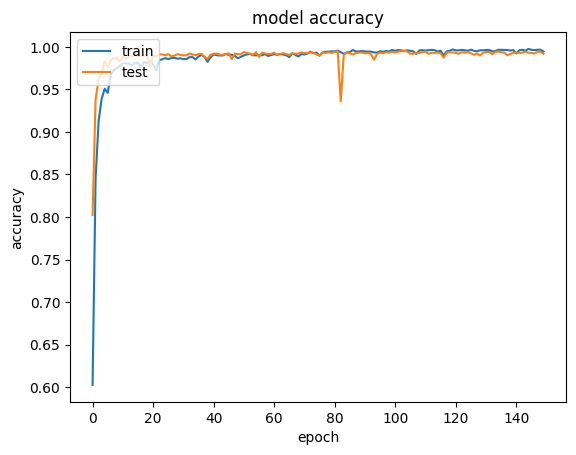

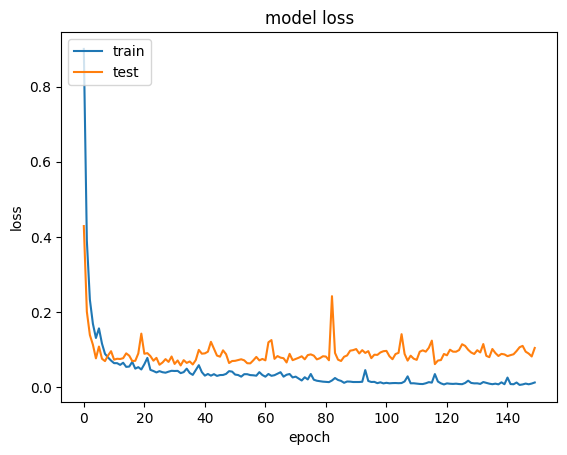

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypred=model.predict(X_train)

434/500 [=========================>....] - ETA: 0s

In [ ]:
Y_train

<tf.Tensor: shape=(16000,), dtype=int64, numpy=array([3, 3, 3, ..., 1, 0, 1])>

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(Y_val,ypred)

ValueError: ignored

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
  layer = model.layers[i]
 # check for convolutional layer
  if 'conv' not in layer.name:
    continue
 # summarize output shape
  print(i, layer.name, layer.output.shape)

0 conv_1 (None, 68, 159, 64)
2 conv_2 (None, 34, 79, 32)
4 conv_3 (None, 17, 39, 16)


In [ ]:
from keras.models import Model
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)

In [ ]:
# load the image with the required shape
from keras.preprocessing.image import load_img
img = load_img(r'/content/train/images/0a2a659c989b.jpg', target_size=(136, 318))

In [ ]:
# convert the image to an array
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input

img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

In [ ]:
# get feature map for first hidden layer
feature_maps = model.predict(img)

1/1 [==============================] - 0s 81ms/step


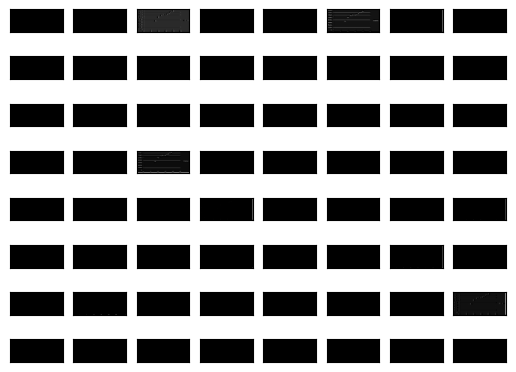

In [ ]:
import matplotlib.pyplot as pyplot
square = 8
ix = 1
for _ in range(square):
  for _ in range(square):
 # specify subplot and turn of axis
    ax = pyplot.subplot(square, square, ix)
    ax.set_xticks([])
    ax.set_yticks([])
 # plot filter channel in grayscale
    pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
    ix += 1
# show the figure
#pyplot.figure(figsize=(18  ,18))
pyplot.savefig('filters.jpg', dpi=1300)


In [ ]:
X_train.shape

TensorShape([16000, 136, 318, 3])

In [ ]:

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# fit model no training data
tf.experimental.numpy.experimental_enable_numpy_behavior()
model = XGBClassifier()
X_train2 = X_train.reshape(X_train.shape[0], -1)
model.fit(X_train, Y_train)

ValueError: ignored